# Trabalho de Machine Learning
## Classificação de emails de phishing

**Dataset**: https://www.kaggle.com/datasets/ethancratchley/email-phishing-dataset

Membros do grupo:

**Gustavo Vieira Ferreira** - 13672690


**Lucas Vizzotto de Castro** - 13672915


**Samuel Figueiredo Veronez** - 12542626

In [1]:
# Importando as bibliotecas

# Analise do BD
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos, e ferramentas utilizadas para treinar, testar e mais
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# modelos utilizados
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

Loading The Dataset

In [2]:
dataset = pd.read_csv("email_phishing_data.csv")
dataset

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
0,140,94,52,0,0,0,0,0,0
1,5,5,1,0,0,0,0,0,0
2,34,32,15,0,0,0,0,0,0
3,6,6,2,0,0,0,0,0,0
4,9,9,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
524841,782,327,301,2,2,2,52,1,0
524842,36,30,11,0,0,0,4,0,1
524843,61,46,11,0,0,0,3,0,0
524844,213,136,89,0,0,0,18,0,0


## Descrição dos dados:

In [3]:
dataset.dtypes

num_words              int64
num_unique_words       int64
num_stopwords          int64
num_links              int64
num_unique_domains     int64
num_email_addresses    int64
num_spelling_errors    int64
num_urgent_keywords    int64
label                  int64
dtype: object

O fato de serem todos atributos numéricos facilita a análise e construção dos modelos, já que não será necessário converter atributos categóricos para numéricos.

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format)
dataset.describe()

,num_words,num_unique_words,num_stopwords,num_links,num_unique_domains,num_email_addresses,num_spelling_errors,num_urgent_keywords,label
count,524846.00,524846.00,524846.00,524846.00,524846.00,524846.00,524846.00,524846.00,524846.00
mean,276.23,123.01,80.05,0.90,0.35,2.11,24.69,0.25,0.01
std,3335.46,201.63,1023.33,5.60,1.77,13.59,311.31,0.56,0.11
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,47.00,38.00,12.00,0.00,0.00,0.00,2.00,0.00,0.00
50%,120.00,79.00,34.00,0.00,0.00,0.00,8.00,0.00,0.00
75%,269.00,145.00,79.00,0.00,0.00,1.00,22.00,0.00,0.00
max,2339682.00,51251.00,720411.00,824.00,524.00,1150.00,190104.00,7.00,1.00


Como é possível observar pelo valor de max, existe um outlier com um número muito grande de palavras (mais de 2 milhões), que não faz sentido no contexto analisado. Vejamos a seguir os 10 emails com mais palavras para fazer uma comparação:

In [5]:
print("10 valores mais altos de num_words:")
print(dataset['num_words'].sort_values(ascending=False).head(10))

print("--- ---")
#gets .99 quantile
print("99% das mensagens tem menos que:")
print(str(dataset['num_words'].quantile(0.99))+" palavras")

10 valores mais altos de num_words:
518898    2339682
111750     103407
357879     101796
316618      63501
316072      55145
316615      49961
316164      46124
316178      45654
254930      42844
74046       41250
Name: num_words, dtype: int64
--- ---
99% das mensagens tem menos que:
2301.0 palavras


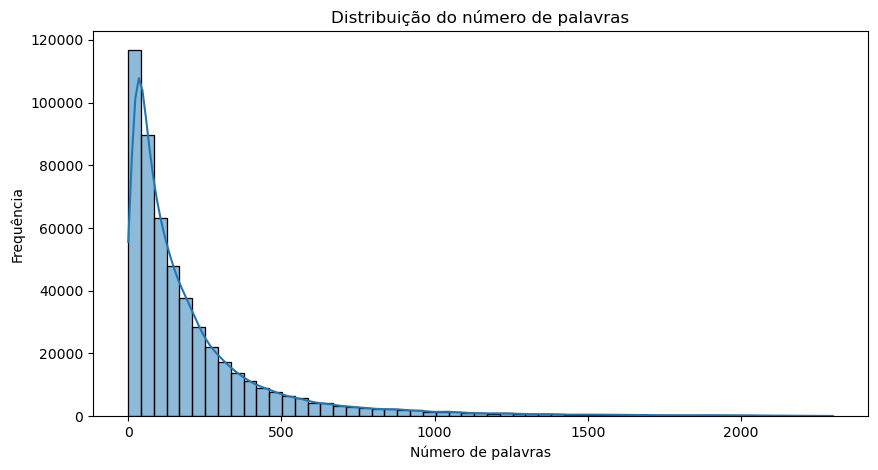

In [6]:
# Remove os 1% maiores, pra que seja possível ver o histograma sem distorçoes
dataset_for_histogram = dataset[dataset['num_words'] < dataset['num_words'].quantile(0.99)]

# TODO escolher os 99%?

# plota o histograma
plt.figure(figsize=(10, 5))
plt.title("Distribuição do número de palavras")
plt.xlabel("Número de palavras")
plt.ylabel("Frequência")
sns.histplot(dataset_for_histogram['num_words'], bins=55, kde=True)
plt.show()

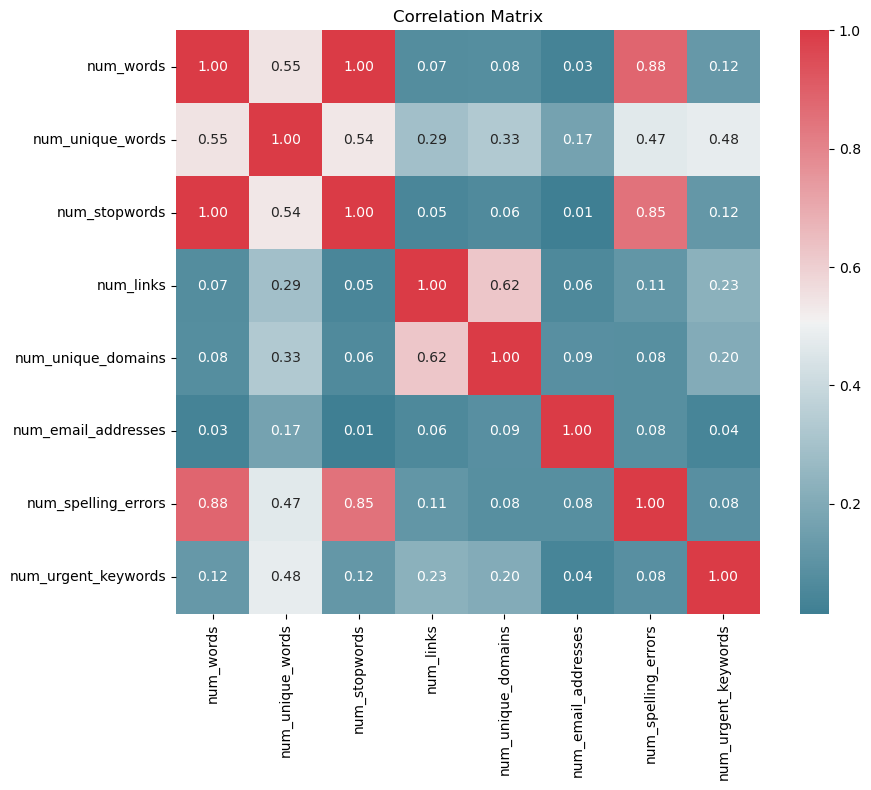

In [7]:
# Matriz de correlação

plt.figure(figsize=(10, 8))

_columns = dataset.columns.drop("label")
corr = dataset[_columns].corr()

sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True), fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Verificação de desbalanceamento

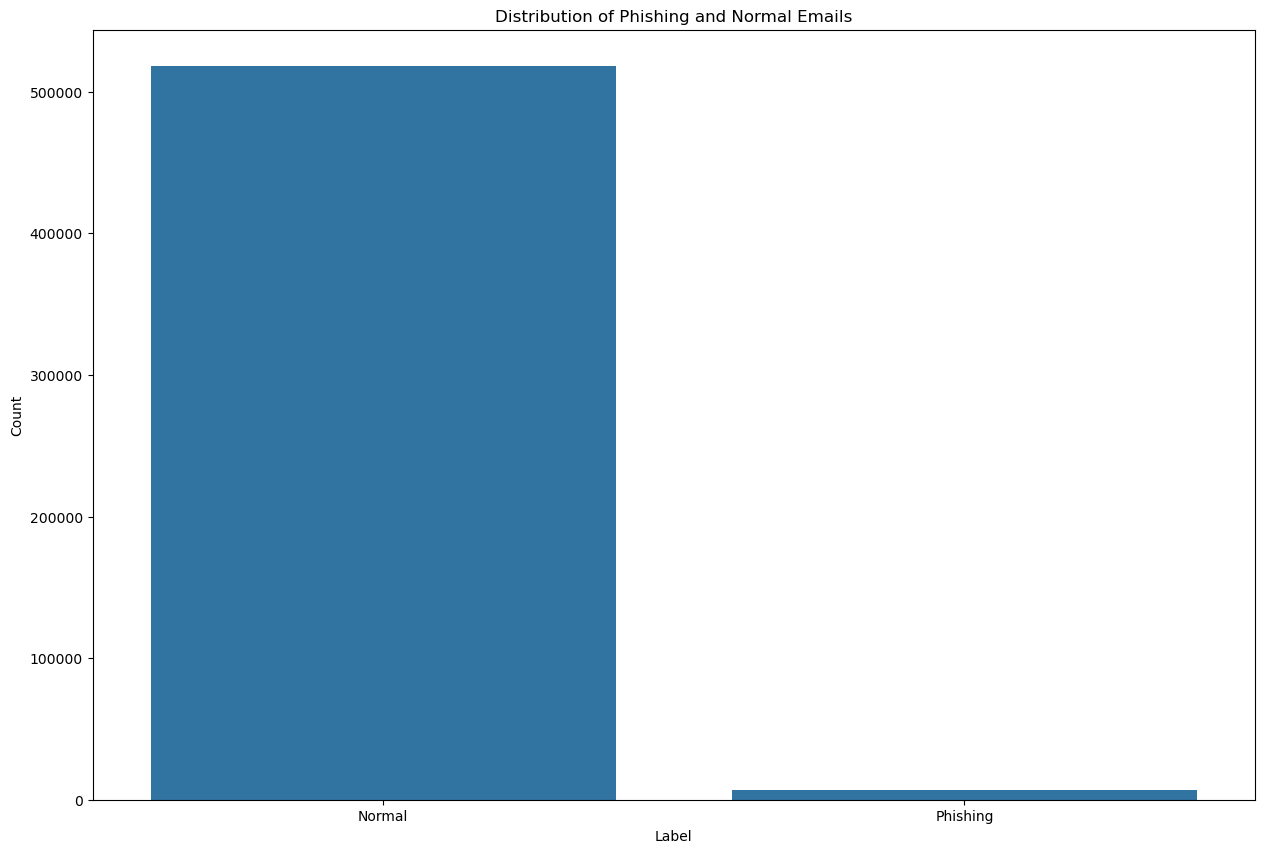

In [8]:
plt.figure(figsize=(15, 10))

sns.countplot(x='label', data=dataset)
plt.title('Distribution of Phishing and Normal Emails')

plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Phishing'])
plt.show()

In [9]:
counts = dataset['label'].value_counts()
print(f"Emails normais: {counts[0]}")
print(f"Emails de phishing: {counts[1]}")
print(dataset['label'].value_counts(normalize=True) * 100)

Emails normais: 517897
Emails de phishing: 6949
label
0   98.68
1    1.32
Name: proportion, dtype: float64


Percebe-se que os dados estão bastante desbalanceados, com apenas pouco mais de 1% pertencendo à classe "Phishing". Para que os modelos possam ser treinados corretamente, devemos balancear esses dados, o que pode ser feito tanto por undersampling (reduzindo a classe majoritária) ou oversampling (aumentando a classe minoritária). No nosso caso, escolheremos o método de undersampling para o overfitting de dados que seria causada pelo oversampling.

Emails normais: 517897
Emails de phishing: 6949


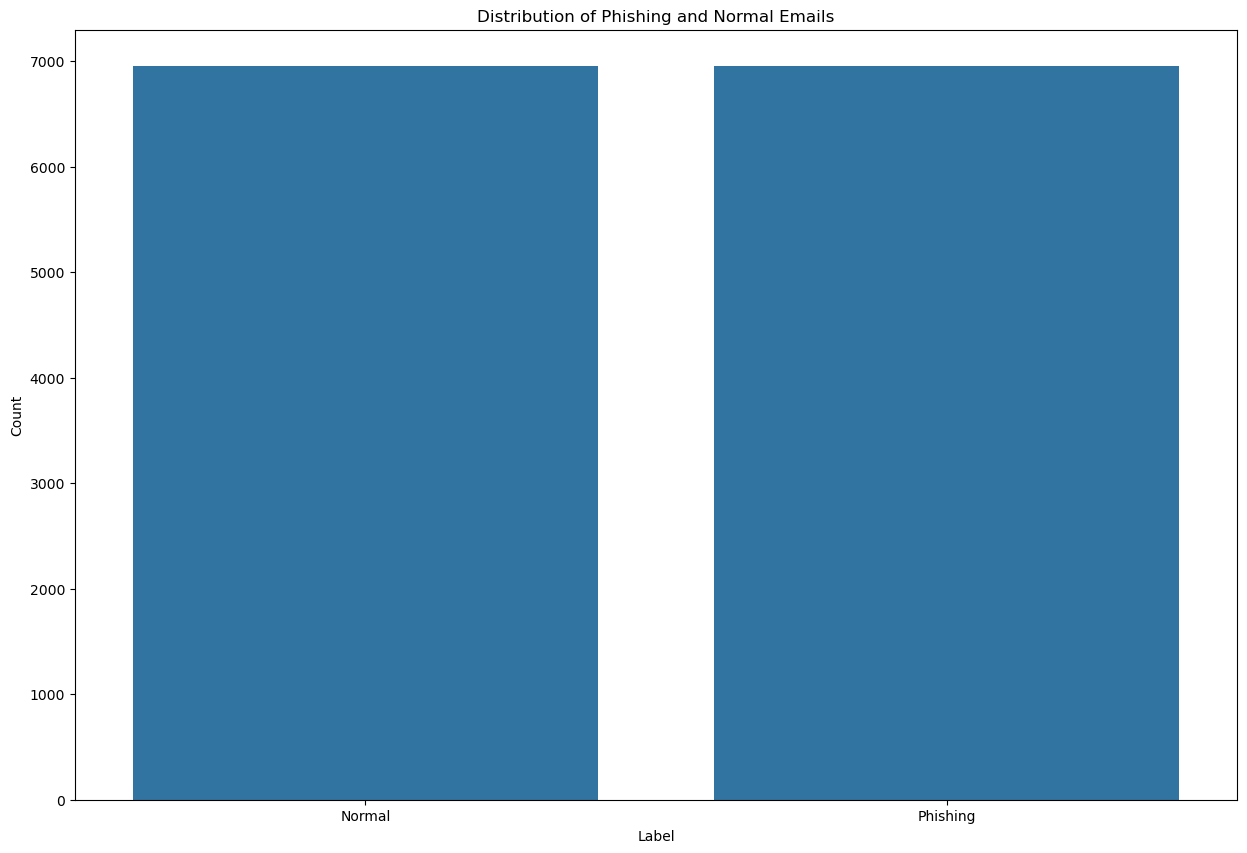

Quantidade total de emails balanceados:13898


In [10]:
normal_emails = dataset[dataset['label'] == 0]
phishing_emails = dataset[dataset['label'] == 1]
print(f"Emails normais: {len(normal_emails)}")
print(f"Emails de phishing: {len(phishing_emails)}")

# balancea os dois conjuntos
normal_emails_balanced = normal_emails.sample(len(phishing_emails), random_state=42)

# Junta os conjuntos balanceados e embaralha os valores 
balanced_dataset = pd.concat([normal_emails_balanced, phishing_emails]).sample(frac=1, random_state=42).reset_index(drop=True)

plt.figure(figsize=(15, 10))
sns.countplot(x='label', data=balanced_dataset)
plt.title('Distribution of Phishing and Normal Emails')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['Normal', 'Phishing'])
plt.show()

print("Quantidade total de emails balanceados:" + str(len(balanced_dataset)))

# Separação dos dados e Definição do 5-Fold Cross Validation

In [11]:
# Define o k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Split de dados de treino e teste
# 80% treino e 20% teste
X_train, X_test, y_train, y_test = train_test_split(balanced_dataset.drop(columns=['label']), balanced_dataset['label'], test_size=0.2, random_state=42)

# Otimizando HyperParametros

KNN

In [12]:
# Declara o Pipeline de knn
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

#Grid Search para o parametro k do knn, optimizando pra acurácia, com stratified kfold cross validation
max_k = 64
accuracy = []
for i in range(1,max_k+1):
    knn_pipeline.set_params(knn__n_neighbors = i)
    _acc = cross_val_score(knn_pipeline,X_train,y_train,cv=cv,scoring='accuracy').mean()
    print(i,_acc)
    accuracy.append(_acc)

print(max(accuracy))

1 0.7350249759706404
2 0.728907804930145
3 0.743209845079402
4 0.7397909607536642
5 0.7407812616303717
6 0.7388924487940013
7 0.7400615539956699
8 0.7413201827202205
9 0.739341401372829
10 0.7381717702760868
11 0.7370919054230299
12 0.7377220490813826
13 0.7360137800690622
14 0.7371826425499275
15 0.7335845493645569
16 0.7345737175441832
17 0.7328647203694535
18 0.7361927057544249
19 0.7353826250740298
20 0.7350231555646172
21 0.7331342618213122
22 0.7335848325388271
23 0.7316056466567638
24 0.731605727563698
25 0.7300770314922153
26 0.7316953319935144
27 0.7313357815771674
28 0.7327747923118993
29 0.7294470091942641
30 0.7289972070926255
31 0.7257592306721424
32 0.7278281827978911
33 0.7268385291766587
34 0.7282773376440548
35 0.7264789787603115
36 0.7271085965235908
37 0.7245006828545261
38 0.7236009572908475
39 0.7234214652569443
40 0.7240505571251501
41 0.7222516318928663
42 0.7206326436826247
43 0.7216218523157183
44 0.7198232507111719
45 0.7185639342776791
46 0.717575049272323
47

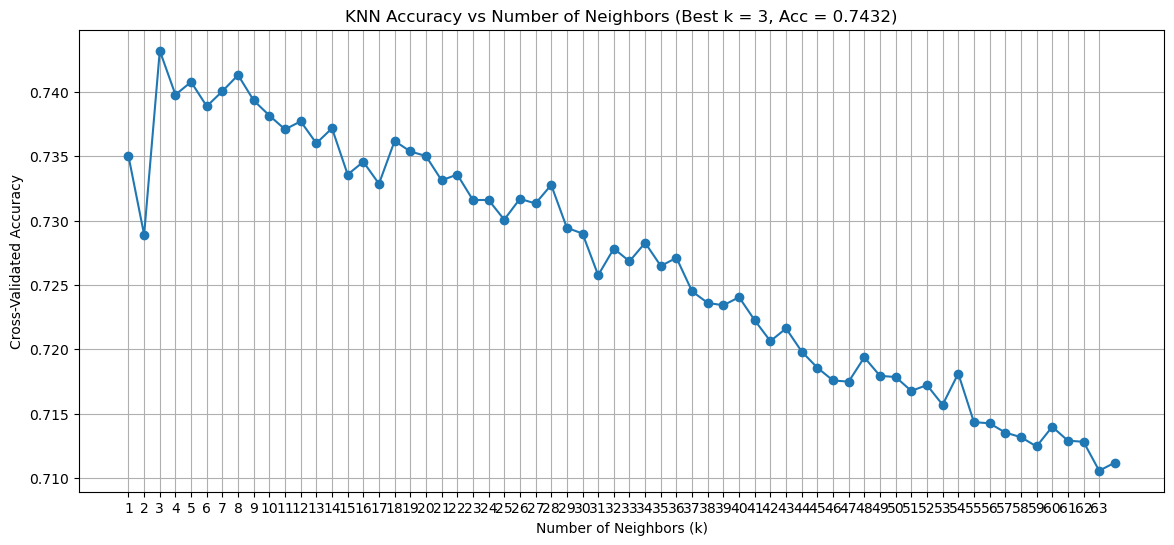

In [13]:
# plotando a acurácia do treino do knn para diferentes k's
best_k = range(1,max_k+1)[accuracy.index(max(accuracy))]
best_acc = max(accuracy)

plt.figure(figsize=(14, 6))
plt.plot(range(1,max_k+1), accuracy, marker='o')
plt.title(f'KNN Accuracy vs Number of Neighbors (Best k = {best_k}, Acc = {best_acc:.4f})')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.xticks(range(1,64))
plt.show()

Logistic Regression

In [14]:
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000))
])

#otimiza para C value
C_values = [0.001, 0.01, 0.1, 1, 10,100]
accuracy = []
for c in C_values:
    logreg_pipeline.set_params(logreg__C=c)
    _acc = cross_val_score(logreg_pipeline,X_train, y_train,cv=cv,scoring='accuracy').mean()
    accuracy.append(_acc)

print(accuracy)
print(max(accuracy))

[0.5648503059900258, 0.6075730913245112, 0.6439103373171908, 0.644540845056748, 0.6444512406269316, 0.6443613125693777]
0.644540845056748


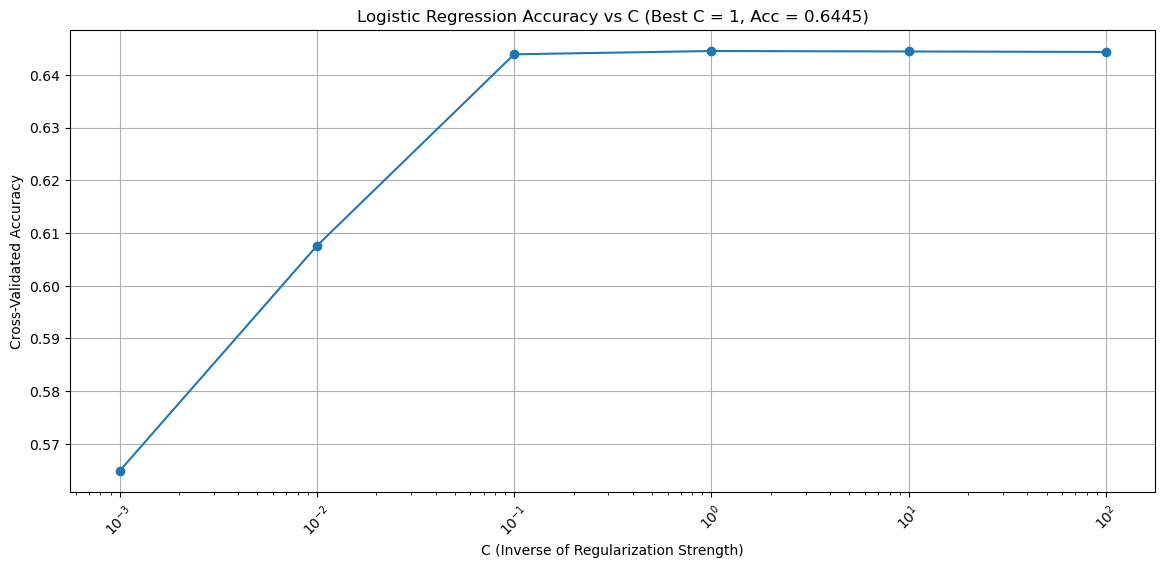

In [15]:
# Plotting with your desired format
best_C = C_values[accuracy.index(max(accuracy))]
best_acc = max(accuracy)

plt.figure(figsize=(14, 6))
plt.plot(C_values, accuracy, marker='o')
plt.title(f'Logistic Regression Accuracy vs C (Best C = {best_C}, Acc = {best_acc:.4f})')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.xscale('log')  
plt.xticks(C_values, rotation=45)
plt.show()

Random Forest

In [16]:
#define o random forest
rf = RandomForestClassifier(random_state=42)

max_depth_range = range(1, 33)  # 1-32
accuracy = []


#Busca pelo melhor valor de max_depth
for d in max_depth_range:
    rf.set_params(max_depth=d)
    _acc = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy').mean()
    print(d, _acc)
    accuracy.append(_acc)
print(max(accuracy))


1 0.6513753774308488
2 0.6529044375835363
3 0.6612688796331355
4 0.6713425615782678
5 0.6789877814347711
6 0.6953576814661632
7 0.7048024333569582
8 0.7204535561833934
9 0.7315165276685535
10 0.7383523141001368
11 0.7498654517681402
12 0.757150797580559
13 0.7612880950300489
14 0.7672239940840849
15 0.770642473875151
16 0.7702819525755913
17 0.7747795690573047
18 0.7810757871435645
19 0.7777476803981915
20 0.7763980313724729
21 0.7770288222863005
22 0.7761290562691547
23 0.7771180221814451
24 0.7766685437075441
25 0.7746898028136195
26 0.7749597892536173
27 0.7741503153752303
28 0.7754097531691246
29 0.7754993980524083
30 0.7741503153752303
31 0.7745097848846428
32 0.7736106256695049
0.7810757871435645


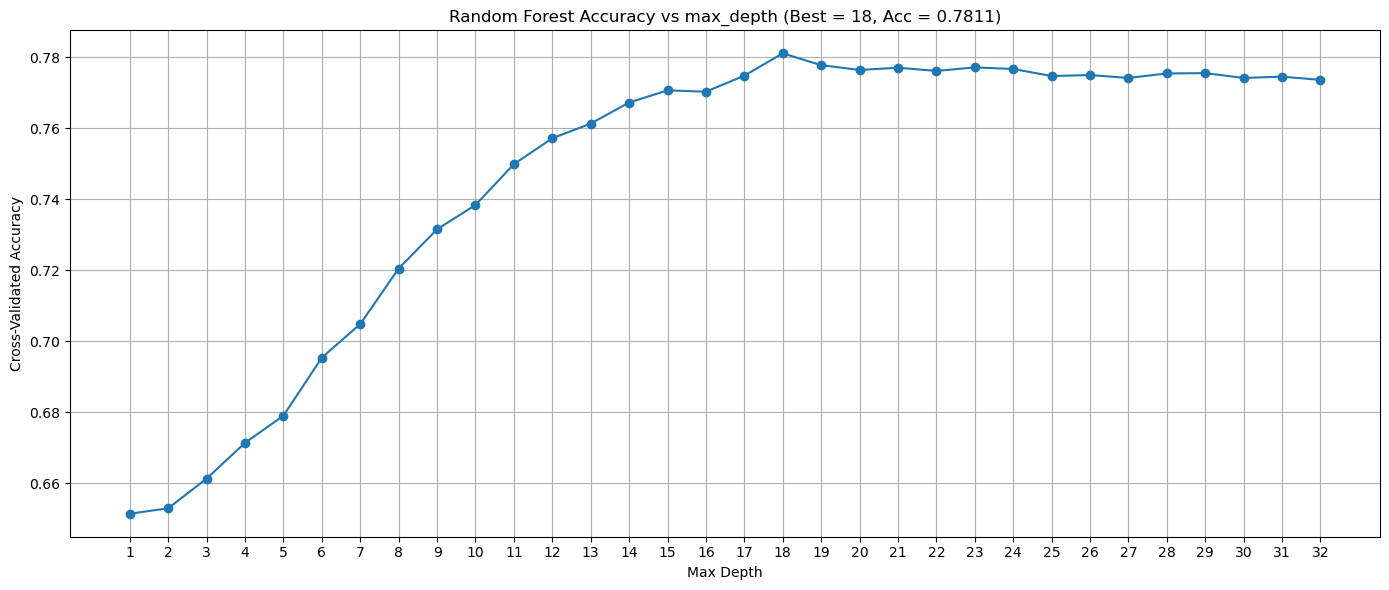

In [17]:
# Encontrar o melhor max_depth
best_depth = max_depth_range[accuracy.index(max(accuracy))]
best_acc = max(accuracy)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(list(max_depth_range), accuracy, marker='o')
plt.title(f'Random Forest Accuracy vs max_depth (Best = {best_depth}, Acc = {best_acc:.4f})')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validated Accuracy')
plt.grid(True)
plt.xticks(list(max_depth_range))
plt.tight_layout()
plt.show()


## Resultados para os HyperParametros Otimizados

In [18]:
# Declara o Pipeline de knn, com o melhor k encontrado
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=best_k))
])

# prepara com os dados de treino
knn_pipeline.fit(X_train,y_train)

# Obtem o resultado para os dados de teste
y_pred_knn = knn_pipeline.predict(X_test)

#knn_pipeline.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.72      0.74      1384
           1       0.74      0.77      0.75      1396

    accuracy                           0.75      2780
   macro avg       0.75      0.75      0.75      2780
weighted avg       0.75      0.75      0.75      2780

KNN Confusion Matrix:
[[ 997  387]
 [ 316 1080]]


In [19]:
# Declara o Pipeline do logistic regression, com o melhor C encontrado
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, C=best_C))
])

logreg_pipeline.fit(X_train,y_train)

# get test set predictions
y_pred_logreg = logreg_pipeline.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.55      0.60      1384
           1       0.62      0.73      0.67      1396

    accuracy                           0.64      2780
   macro avg       0.64      0.64      0.64      2780
weighted avg       0.64      0.64      0.64      2780

Logistic Regression Confusion Matrix:
[[ 755  629]
 [ 373 1023]]


In [20]:
rf = RandomForestClassifier(random_state=42,max_depth=best_depth)

rf.fit(X_train,y_train)

# get test set predictions
y_pred_rf = rf.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1384
           1       0.78      0.81      0.79      1396

    accuracy                           0.79      2780
   macro avg       0.79      0.79      0.79      2780
weighted avg       0.79      0.79      0.79      2780

Random Forest Confusion Matrix:
[[1064  320]
 [ 266 1130]]
